# Problem 2
**Consider i.i.d. data $x_1, ..., x_n$ such that $x_i|\nu, \theta ∼ Gamma(\nu, \theta)$ where $E(x_i) = \nu / \theta$,**
**and assign priors $\nu ∼ Gamma(3, 1)$ and $\theta ∼ Gamma(2, 2)$.**

**(a) Develop a Metropolis-within-Gibbs algorithm to sample from $p(\nu, \theta|x_1, ..., x_n)$**
**using the full conditional distributions $p(\theta|\nu, x_1, ... , x_n)$ and $p(\nu|\theta, x_1, ..., x_n)$.**
**For the second full conditional, use a random walk proposal on $log(ν)$.**

**(b) Develop a Metropolis-Hastings algorithm that jointly proposes $log(\nu)$ and $log(\theta)$**
**using a Gaussian random walk centered on the current value of the parameters.**
**Tune the variance-covariance matrix of the proposal using a test run that proposes the parameters**
**independently (but evaluates acceptance jointly).**

**(c) Develop a Metropolis algorithm that jointly proposes $log(\nu)$ and $log(\theta)$**
**using independent proposals based on the Laplace approximation of the posterior distribution**
**of $log(\nu)$ and $log(\theta)$.**

**(d) Run each of the algorithms for the dataset in my-data.txt and compute the effective**
**sample sizes associated with each parameter under each of the samplers.**
**Also, construct trace and autocorrelation plots.**
**Report posterior means for each of the parameters of interest,**
**along with 95% symmetric credible intervals. Discuss.**



To begin with, the posterior distribution (up to constant) is
$$\pi(\nu, \theta|x) \propto f(x|\nu, \theta)\pi(\nu, \theta) \propto f(x|\nu, \theta)\pi(\nu)\pi(\theta)$$
$$\propto (\frac{\theta^\nu}{\Gamma(\nu)})^n (\prod_{i=1}^n x_i)^{\nu-1} e^{-\theta \sum_{i=1}^{n} x_i} \nu^2 e^{-\nu} \theta e^{-2 \theta}$$

From here, where $w = log(\nu)$, we can get
$$\pi|\nu, x \sim gamma(n\nu + 2, \sum_{i=1}^n x_i + 2 )$$
$$ log{\pi(w| \theta, x)} \propto n e^w log{\theta} - n log{\Gamma(e^w)} + (e^w -1)(\sum_{i=1}^n log{x_i}) + 3w - e^w $$

Next, the joint posterior distribution of $(w, \tau) = (log{\nu}, log{\theta})$ is
$$\pi(w, \tau |x) \propto e^{\tau n e^w} (\Gamma(e^w))^{-n} (\prod_{i=1}^n x_i)^{e^w -1} e^{-e^\tau \sum_{i=1}^n x_i} e^{2w - e^w + \tau - 2e^{\tau} + w + \tau} $$
and
$$ log{\pi(w, \tau |x)} \propto \tau n e^w - n log(\Gamma(e^w)) + (e^w -1)(\sum_{i=1}^n log(x_i)) -e^\tau (\sum_{i=1}^n x_i) + 2w - e^w + \tau - 2e^{\tau} + w + \tau $$

For detailed derivation, please see attached note below.


In [1]:
from random import gammavariate, normalvariate, uniform, seed
from math import lgamma, log, exp
from functools import partial

import numpy as np
from scipy.special import polygamma

from MCMC_MH_Core import MCMC_MH, MCMC_Diag
from MCMC_Gibbs_Core import MCMC_Gibbs
from newton import NewtonUnconstrained



mydata = []
with open("my-data.txt") as f:
    for line in f:
        mydata.append(float(line))
print("data:", mydata[:5],"...")
data_log_sum = sum([log(x) for x in mydata])
data_sum = sum(mydata)

seed(20220226)

data: [5.25644, 6.630203, 1.548099, 1.978492, 2.154677] ...


## (a) Metropolis-within-Gibbs algorithm

Using the two results,

$$\pi|\nu, x \sim gamma(n\nu + 2, \sum_{i=1}^n x_i + 2 )$$
$$ log{\pi(w| \theta, x)} \propto n e^w log{\theta} - n log{\Gamma(e^w)} + (e^w -1)(\sum_{i=1}^n log{x_i}) + 3w - e^w $$

where $w=log \nu$
we can implement the metropolis-within-gibbs sampler for $(\nu, \theta)$.
To sample $\nu$, I will use a MH algorithm, with gaussian proposal with sd $0.1$.


Let's draw 30000 samples. I set the initial point as $(1,1)$.

In [2]:
class Gibbs_with_MH(MCMC_Gibbs):
    def __init__(self, data, initial): #override
        self.data = data
        self.n = len(data)
        self.MC_sample = [initial]

    def get_data_sum(self):
        if not hasattr(self, 'data_sum'):
            self.data_sum = sum(self.data)
        return self.data_sum

    
    def get_data_log_sum(self):
        if not hasattr(self, 'data_log_sum'):
            self.data_log_sum = sum([log(x) for x in self.data])
        return self.data_log_sum

    # full-conditionals implementation

    def full_conditional_sampler_theta(self, last_param):
        nu = last_param[0]
        # theta = last_param[1] #not used
        shape = self.n * nu + 2 
        rate = self.get_data_sum() + 2
        new_theta = gammavariate(shape, 1/rate)
        return [nu, new_theta]

    def full_conditional_sampler_log_nu(self, last_param):
        nu = last_param[0]
        log_nu = log(nu)
        theta = last_param[1]

        def log_log_nu_density_kernel(eval_pt, theta, data_log_sum, data_num):
            log_nu = eval_pt[0]
            nu = exp(log_nu)
            log_kernel = (data_num*nu)*log(theta) - (data_num)*lgamma(nu) + (nu-1)*data_log_sum + 3*log_nu - nu
            return log_kernel
                    
        def gaussian_sampler(last, sd):
            last = last[0]
            sample = normalvariate(last, sd)
            return [sample]

        def symmetric_log_density_kernel(from_smpl, to_smpl):
            return 0 #no need to implement
        
        log_log_nu_density_kernel_for_log_nu = partial(log_log_nu_density_kernel, theta=theta, data_log_sum=self.get_data_log_sum(), data_num=self.n)
        gaussian_sampler_sd1 = partial(gaussian_sampler, sd=0.1)
        mcmc_mh_inst = MCMC_MH(log_log_nu_density_kernel_for_log_nu, symmetric_log_density_kernel, gaussian_sampler_sd1, [log_nu], random_seed=uniform(0,1))
        mcmc_mh_inst.generate_samples(1, verbose=False)
        new_log_nu = mcmc_mh_inst.MC_sample[-1]
        return [exp(new_log_nu[0]), theta]

    # main-sampler
    
    def gibbs_sampler(self): #override
        last = self.MC_sample[-1]
        new = [x for x in last] #[nu, theta]
        new = self.full_conditional_sampler_log_nu(new)
        new = self.full_conditional_sampler_theta(new)
        self.MC_sample.append(new)


#Gibbs

gibbs_inst = Gibbs_with_MH(mydata, [1,1])
gibbs_inst.generate_samples(30000, print_iter_cycle=10000)

estimated running time:  0.0 min  0.8980035781860352 sec
iteration 10000 / 30000
iteration 20000 / 30000
iteration 30000 / 30000  done! (elapsed time for execution:  0.0 min  0.5801863670349121 sec)


I cut first 3000 samples. (the number is determined by observing the trace plot before burn-in.)
To compare it with other results in (b) and (c), I intentionally do not thin the samples.

Note that, here, 0-th dim is $\nu$, and 1-th dim is $\theta$ (The index of python is started with 0, haha.)
And, for the below scatterplot, the horizontal axis is $\nu$ and vertical is $\theta$.
(oh... later, if I have time, I'll make the function apply the variable name in a figure...)

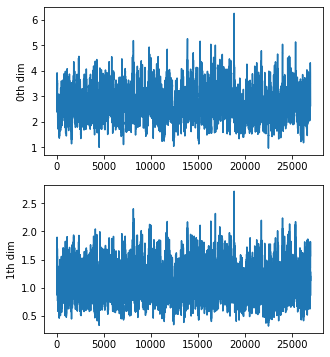

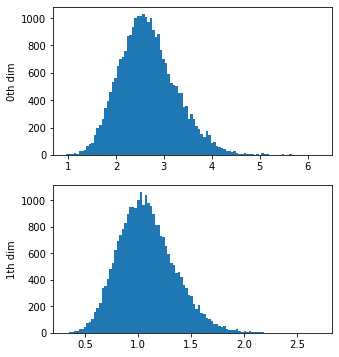

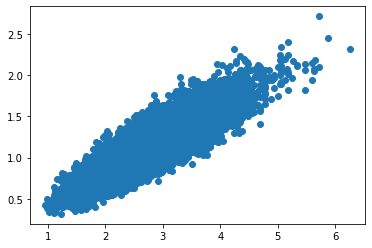

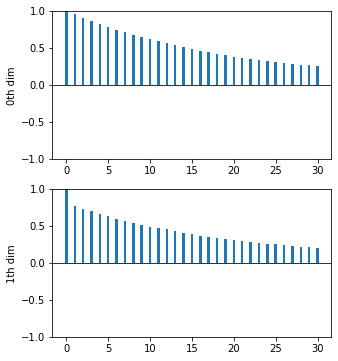

In [3]:
gibbs_diag_inst = MCMC_Diag()
gibbs_diag_inst.set_mc_sample_from_MCMC_MH(gibbs_inst)
gibbs_diag_inst.burnin(3000)
gibbs_diag_inst.show_traceplot((1,2))
gibbs_diag_inst.show_hist((1,2))
gibbs_diag_inst.show_scatterplot(0,1)
gibbs_diag_inst.show_acf(30, (1,2))

I will offer some numerical descriptive statistics when I compare all results.

When checking the trace plots, I think this chain converges well.
The histograms and the scatterplot look fine.
However, when we find the acf plots, we can find that auto-correlations do not vanish enough even if the lag-size is greater than 20.

## (b) Metropolis-Hastings algorithm that jointly proposes log(ν) and log(θ), under a gaussian proposal

Using the result,

$$ log{\pi(w, \tau |x)} \propto \tau n e^w - n log(\Gamma(e^w)) + (e^w -1)(\sum_{i=1}^n log(x_i)) -e^\tau (\sum_{i=1}^n x_i) + 2w - e^w + \tau - 2e^{\tau} + w + \tau $$


where $w=log \nu, \tau=log \theta$, 
we can implement a joint MH sampler for $(\nu, \theta)$.
Following the problem's direction, I will use gaussian proposal with sd $0.1$.


Again, let's draw 30000 samples. I set the initial point as $(1,1)$.

In [4]:
def joint_log_density_kernel(eval_pt, data_num, data_log_sum, data_sum):
    w = eval_pt[0]
    t = eval_pt[1]
    log_kernel = t*data_num*exp(w) - data_num*lgamma(exp(w))
    log_kernel += (exp(w)-1)*data_log_sum
    log_kernel -= exp(t)*data_sum
    log_kernel += (2*w - exp(w) + t - 2*exp(t) + w + t)
    return log_kernel

def gaussian_sampler_2d(last, sd):
    sample0 = normalvariate(last[0], sd)
    sample1 = normalvariate(last[1], sd)
    return [sample0, sample1]

def symmetric_log_density_kernel(from_smpl, to_smpl):
    return 0 #no need to implement

joint_log_density_kernel_with_data = partial(joint_log_density_kernel, data_num=len(mydata), data_log_sum=data_log_sum, data_sum=data_sum)
gaussian_sampler_2d_with_sd = partial(gaussian_sampler_2d, sd=0.1)
mh_inst = MCMC_MH(joint_log_density_kernel_with_data, symmetric_log_density_kernel, gaussian_sampler_2d_with_sd, [1,1], 20220226)
mh_inst.generate_samples(30000, print_iter_cycle=10000)


iteration 0 / 30000
estimated running time:  0.0 min  0.3678560256958008 sec
iteration 10000 / 30000
iteration 20000 / 30000
iteration 30000 / 30000  done! (elapsed time for execution:  0.0 min  0.25238776206970215 sec)
acceptance rate:  0.6357


Using $\nu=e^w, \theta=e^\tau$, we can draw traceplots, histograms, a scatterplot, and acf plots.
For comparison with (a) and (c), I did the same post-sampling work, with cutting 3000 burn-in period and without thinning.

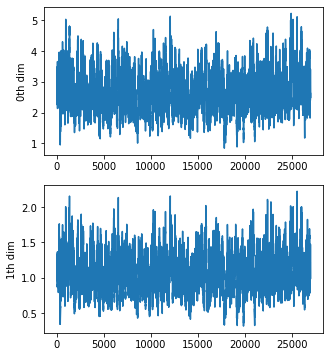

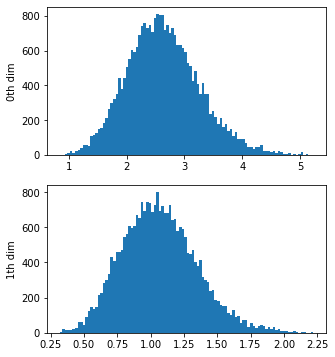

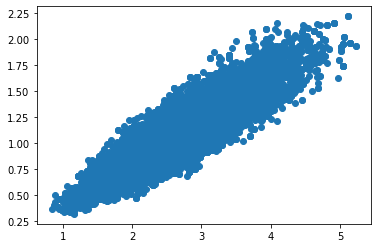

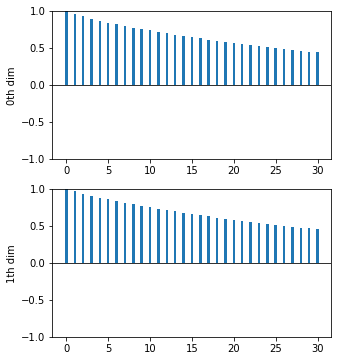

In [5]:
mh_diag_inst2 = MCMC_Diag()
nu_theta_samples = [[exp(sample[0]), exp(sample[1])] for sample in mh_inst.MC_sample]
mh_diag_inst2.set_mc_samples_from_list(nu_theta_samples)
mh_diag_inst2.burnin(3000)
mh_diag_inst2.show_traceplot((1,2))
mh_diag_inst2.show_hist((1,2))
mh_diag_inst2.show_scatterplot(0,1)
mh_diag_inst2.show_acf(30, (1,2))

Everything seems fine except for the autocorrelation.
The acf plots here get worse than (a).

## (c) Independent Metropolis-Hastings algorithm that jointly proposes log(ν) and log(θ), under the Laplace-approximated posterior proposal

Using the result,

$$ log{\pi(w, \tau |x)} \propto \tau n e^w - n log(\Gamma(e^w)) + (e^w -1)(\sum_{i=1}^n log(x_i)) -e^\tau (\sum_{i=1}^n x_i) + 2w - e^w + \tau - 2e^{\tau} + w + \tau $$


where $w=log \nu, \tau=log \theta$, 

we can approximate the joint posterior distribution of $w, \tau$ by a Gaussian distribution using the Laplace approximation.
To this work, let 

$$q(w, \tau) = \tau n e^w - n log(\Gamma(e^w)) + (e^w -1)(\sum_{i=1}^n log(x_i)) -e^\tau (\sum_{i=1}^n x_i) + 2w - e^w + \tau - 2e^{\tau} + w + \tau$$

Then,
- $\frac{\partial^2 q}{\partial w^2} = \tau n e^w + (\frac{\Gamma'(e^w)}{\Gamma(e^w)})^2 e^{2w} -n \frac{\Gamma''(e^w)}{\Gamma(e^w)} e^{2w} - n \frac{\Gamma'(e^w)}{\Gamma(e^w)}e^w + e^w (\sum_{i=1}^n log x_i) - e^w $
- $\frac{\partial^2 q}{\partial w^2} = ne^w$
- $\frac{\partial^2 q}{\partial w^2} = -e^{\tau}(\sum_{i=1}^n x_i) - 2e^{\tau}$

Fortunately, we can find digamma/polygamma function in the scipy. I decided to use the function (cause implementing these gamma-derivative functions is not our main work.)

Note that, the Laplace-approximated posterior is
$$w, \tau ~ N_2((w^*, \tau^*, (-H)^{-1})$$

where $w^*, \tau^*$ is a mode of $q$, and H is the hessian matrix of $q$.
Using the second derivatives, we can construct H.

In the next code-block, I will find the mode using the newton method,
and get the the Laplace-approximated posterior.

(Actually, the initial point for the newton method matters, cause we should find a initial point that the hessian is positive definite (for minimization).
I did some trials, and set the initial as $(2, 0.5)$.

In [6]:
# Laplace approximation

def joint_log_density_kernel_neg(eval_pt, data_num, data_log_sum, data_sum):
    return joint_log_density_kernel(eval_pt, data_num, data_log_sum, data_sum)*(-1)

def joint_log_density_kernel_neg_gradient(eval_pt, data_num, data_log_sum, data_sum):
    w = eval_pt[0]
    nu = exp(w)
    t = eval_pt[1]

    dq_dw = t*data_num*nu - data_num*polygamma(0, nu)*nu + nu*data_log_sum + 3 - nu
    dq_dt = data_num*nu - exp(t)*data_sum + 2 - 2*exp(t)
    return np.array([dq_dw, dq_dt])*(-1)

def joint_log_density_kernel_neg_hessian(eval_pt, data_num, data_log_sum, data_sum):
    w = eval_pt[0]
    nu = exp(w)
    t = eval_pt[1]

    d2q_dw2 = t*data_num*nu + data_num*(polygamma(0,nu)**2)*(nu**2)
    d2q_dw2 -= data_num*(polygamma(1,nu) + polygamma(0,nu)**2)*nu**2
    d2q_dw2 -= data_num*(polygamma(0,nu))*nu
    d2q_dw2 += (nu*data_log_sum - nu)

    d2q_dwdt = data_num*nu
    d2q_d2t = -exp(t)*(data_sum+2)
    return np.array([[d2q_dw2, d2q_dwdt],[d2q_dwdt, d2q_d2t]])*(-1)

newton_objective = partial(joint_log_density_kernel_neg, data_num=len(mydata), data_log_sum=data_log_sum, data_sum=data_sum)
newton_gradient = partial(joint_log_density_kernel_neg_gradient, data_num=len(mydata), data_log_sum=data_log_sum, data_sum=data_sum)
newton_hessian = partial(joint_log_density_kernel_neg_hessian, data_num=len(mydata), data_log_sum=data_log_sum, data_sum=data_sum)
newton_inst = NewtonUnconstrained(newton_objective, newton_gradient, newton_hessian)

newton_inst.run_newton_with_backtracking_line_search(np.array([2, 0.5]), method="cholesky")
mode = newton_inst.get_arg_min()
print("laplace approximation - mode:", mode)
laplace_approx_cov = np.linalg.inv(newton_hessian(mode))
print("laplace approximation - cov matrix:\n", laplace_approx_cov)


iteration:  4
laplace approximation - mode: [1.00682976 0.10101   ]
laplace approximation - cov matrix:
 [[0.05254703 0.05109953]
 [0.05109953 0.06390432]]


Now, we are ready to implement a joint MH sampler for $(\nu, \theta)$ with the approximated gaussian distribution as a proposal.
Again, let's draw 30000 samples. I set the initial point as $(1,1)$.

In [7]:
def multivariate_normal_sampler(last, mean, cov):
    #last: not used (independent proposal)
    return np.random.multivariate_normal(mean, cov)
laplace_approxed_sampler = partial(multivariate_normal_sampler, mean=mode, cov=laplace_approx_cov)

def log_multivariate_normal_density(from_smpl, to_smpl, mean, inv_cov):
    #from_smpl: not used (independent proposal)
    to_smpl = np.array(to_smpl)
    kernel = -0.5 * (to_smpl-mean).transpose() @ inv_cov @ (to_smpl-mean)
    return kernel

laplace_approxed_log_density = partial(log_multivariate_normal_density, mean=mode, inv_cov = newton_hessian(mode))
mh_laplace_inst = MCMC_MH(joint_log_density_kernel_with_data, laplace_approxed_log_density, laplace_approxed_sampler, mode, 20220227+10)
mh_laplace_inst.generate_samples(30000, print_iter_cycle=10000)

iteration 0 / 30000
estimated running time:  0.0 min  5.692720413208008 sec
iteration 10000 / 30000
iteration 20000 / 30000
iteration 30000 / 30000  done! (elapsed time for execution:  0.0 min  3.109640121459961 sec)
acceptance rate:  0.8638


We can observe that the acceptance rate here got higher than (b)

Like (b), using $\nu=e^w, \theta=e^\tau$, we can draw traceplots, histograms, a scatterplot, and acf plots of $\nu, \theta$.
For comparison with (a) and (b), I cut 3000 burn-in period and do not thin.

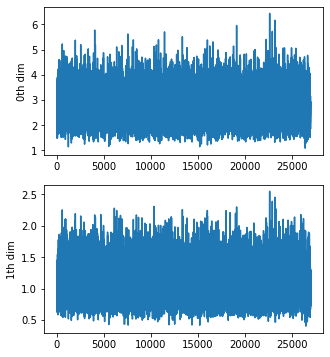

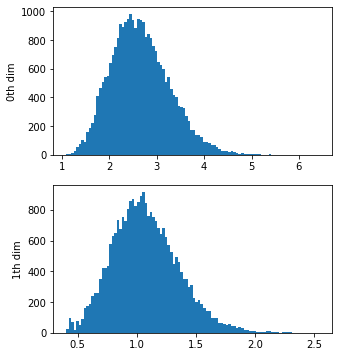

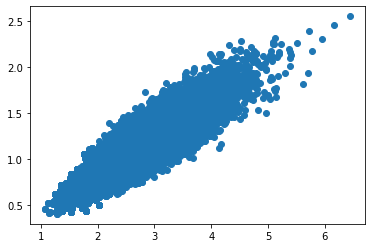

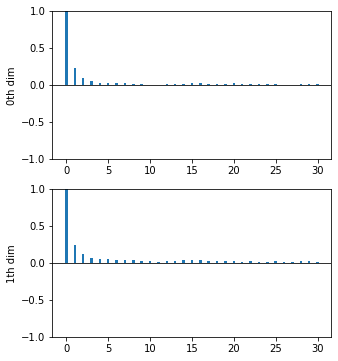

In [8]:
mh_laplace_diag_inst2 = MCMC_Diag()
laplace_nu_theta_samples = [[exp(sample[0]), exp(sample[1])] for sample in mh_laplace_inst.MC_sample]
mh_laplace_diag_inst2.set_mc_samples_from_list(laplace_nu_theta_samples)
mh_laplace_diag_inst2.burnin(3000)
mh_laplace_diag_inst2.show_traceplot((1,2))
mh_laplace_diag_inst2.show_hist((1,2))
mh_laplace_diag_inst2.show_scatterplot(0,1)
mh_laplace_diag_inst2.show_acf(30, (1,2))


We can find that the acf plot is improved so much without any thinning.


## comparison

Let's calculate descriptive statistics, including mean, median, and 0.025 and 0.975 emp. quantiles.
Using 0.025 and 0.975th quantiles, we can construct a 95% credible interval for each case.

In [9]:
print("gibbs:   mean:", gibbs_diag_inst.get_sample_mean())
print("gibbs:quantile:", gibbs_diag_inst.get_sample_quantile([0.025, 0.5, 0.975]))
print("gibbs: 0d ess:", gibbs_diag_inst.effective_sample_size(0))
print("gibbs: 1d ess:", gibbs_diag_inst.effective_sample_size(1))

print("MH:   mean:", mh_diag_inst2.get_sample_mean())
print("MH:quantile:", mh_diag_inst2.get_sample_quantile([0.025, 0.5, 0.975]))
print("MH: 0d ess:", mh_diag_inst2.effective_sample_size(0))
print("MH: 1d ess:", mh_diag_inst2.effective_sample_size(1))

print("MH_laplace:   mean:", mh_laplace_diag_inst2.get_sample_mean())
print("MH_laplace:quantile:", mh_laplace_diag_inst2.get_sample_quantile([0.025, 0.5, 0.975]))
print("MH_laplace: 0d ess:", mh_laplace_diag_inst2.effective_sample_size(0))
print("MH_laplace: 1d ess:", mh_laplace_diag_inst2.effective_sample_size(1))

gibbs:   mean: [2.669719235920818, 1.0810809247022501]
gibbs:quantile: [[1.6373362519383452, 2.6239008025502613, 3.9581747118486756], [0.6222673889590996, 1.0603916612922153, 1.6600336279433245]]
gibbs: 0d ess: 794.5094954975885
gibbs: 1d ess: 972.3622959163146
MH:   mean: [2.637593221995151, 1.0680407328097747]
MH:quantile: [[1.5062657598791722, 2.598062239584797, 3.9955737612094393], [0.568939812066766, 1.0530316497524084, 1.6769041724413676]]
MH: 0d ess: 639.7100258623333
MH: 1d ess: 627.4784907246601
MH_laplace:   mean: [2.657899347377608, 1.0743660552485972]
MH_laplace:quantile: [[1.6103819443113632, 2.6070602496369135, 4.0040334643104], [0.5836949135025455, 1.0533034851858694, 1.6787752452206284]]
MH_laplace: 0d ess: 6272.6951944739085
MH_laplace: 1d ess: 5281.43990675271


Except for MH's 0.025 quantile values, every mean and quantile value is similar for 3 cases.
I think, MH stayed at too lower value of $(\nu, \theta)$ for a while.
This is quite likely to be realized, cause our target posterior is highly correlated.
Specifically, at the tail parts where the range having a (relatively) high mass is too thin, a gaussian proposal like (b) performs poorly in MH.

Interestingly, however, ESSs are quite different each other.
The independent proposal case (c) is the best, 
but I think it is natural cause our true posterior shapes easy to be approximated by a gaussian distribution, so Laplace approximation worked well in our case. 
Moreover, since ESS depends on the autocorrelation,
good independent proposal could improve the ESS so much.
